In [1]:
from __future__ import division

import PerformParser as pp
import pandas as pd
import numpy as np
from scipy import signal as sig
import performFun as pF

import bokeh.plotting as bkP
import bokeh.models as bkM
from bokeh.palettes import Spectral6
bkP.output_notebook() 

import cv2
import os
import scipy.io as sio
import matplotlib

%matplotlib notebook
from ipywidgets import interact
import filterpy as fP
from bokeh.io import push_notebook

import Quaternion as qu

import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz
from scipy.fftpack import fft
from mpl_toolkits.mplot3d import Axes3D

bkP.output_notebook()

#bkP.output_file('timeSeries.html') 

#%pylab inline
#%matplotlib notebook


BokehJS successfully loaded.

/Users/kamranbinaee/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


BokehJS successfully loaded.

In [2]:
#fileTime = '2016-4-22-11-57'
#fileTime = '2016-4-27-13-28'
#fileTime = '2016-4-28-10-57'
#fileTime = '2016-4-29-11-56'
#fileTime = '2016-5-3-12-52'
#fileTime = '2016-5-4-13-3'
#fileTime = '2016-5-5-13-7'
#fileTime = '2016-5-6-11-2'
fileTime = '2016-5-6-13-4'
expCfgName = "gd_pilot.cfg"
sysCfgName = "PERFORMVR.cfg"

filePath = "../Data/exp/" + fileTime + "/"
fileName = "exp_data-" + fileTime

sessionDict = pF.loadSessionDict(filePath,fileName,expCfgName,sysCfgName,startFresh=False)

rawDataFrame = sessionDict['raw']
processedDataFrame = sessionDict['processed']
calibDataFrame = sessionDict['calibration']
s1TrialInfo = sessionDict['trialInfo']

In [3]:
rawDataFrame.eyeTimeStamp.values.astype(float)

array([  8.05288842e+11,   8.05305464e+11,   8.05322112e+11, ...,
         1.95762151e+12,   1.95763818e+12,   1.95765478e+12])

In [4]:
 def calcSMIDeltaT(sessionDict):
        #pd.to_datetime(sessionDict['raw']['eyeTimeStamp'].values
        sessionDict['processed']['frameTime'] = pd.to_datetime(rawDataFrame.eyeTimeStamp.values.astype(long), unit='ns')
        deltaTime = sessionDict['processed']['frameTime'].diff()
        deltaTime.loc[deltaTime.dt.microseconds==0] = pd.NaT
        deltaTime = deltaTime.fillna(method='bfill', limit=1)
        sessionDict['processed']['vizardDeltaT'] = deltaTime.dt.microseconds / 1000000

        print '*** calcVizardDeltaT(): Added sessionDict[\'processed\'][\'frameTime\'] ***'

        return sessionDict

In [5]:
 def calcVizardDeltaT(sessionDict):
        #pd.to_datetime(sessionDict['raw']['eyeTimeStamp'].values
        sessionDict['processed']['frameTime'] = pd.to_datetime(sessionDict['raw']['frameTime'].values, unit='ns')
        deltaTime = sessionDict['processed']['frameTime'].diff()
        deltaTime.loc[deltaTime.dt.microseconds==0] = pd.NaT
        deltaTime = deltaTime.fillna(method='bfill', limit=1)
        sessionDict['processed']['vizardDeltaT'] = deltaTime.dt.microseconds / 1000000

        print '*** calcVizardDeltaT(): Added sessionDict[\'processed\'][\'frameTime\'] ***'

        return sessionDict

In [6]:
#rawDataFrame['eyeTimeStamp'].values
sessionDict = calcSMIDeltaT(sessionDict)
#sessionDict = calcVizardDeltaT(sessionDict)

timeArray = rawDataFrame.frameTime.values
timeArray_shifted = np.roll(timeArray, -1)
timeDiff = timeArray_shifted -  timeArray

#from datetime import datetime
#datetime.fromtimestamp(sessionDict['raw']['eyeTimeStamp'].values[0])
#sessionDict['raw']['eyeTimeStamp'].values[0]

*** calcVizardDeltaT(): Added sessionDict['processed']['frameTime'] ***


In [7]:
sessionDict['processed']['frameTime'] = pd.to_datetime(rawDataFrame.eyeTimeStamp.values.astype(long), unit='ns')
deltaTime = sessionDict['processed']['frameTime'].diff()
deltaTime.loc[deltaTime.dt.microseconds==0] = pd.NaT
deltaTime = deltaTime.fillna(method='bfill', limit=1)
sessionDict['processed']['vizardDeltaT'] = deltaTime.dt.microseconds / 1000000
#sessionDict['processed']['vizardDeltaT']

In [8]:
#pF.plotMyData_2D(ses)
#pF.plotMyData_2D([, ], 'TimeStamp Differences', color, marker, axisLabels, dataRange = None)
gbTrial = sessionDict['processed'].groupby(['trialNumber'])
rawTimeStamp = gbTrial.get_group(4)['vizardDeltaT'].values

#sessionDict['processed']['vizardDeltaT'].values[startFrame:frameCount]

startFrame = 0
frameCount = len(rawTimeStamp)
filteredData = pd.rolling_median(rawTimeStamp, 7, min_periods = 0)

fig1 = plt.figure()
plt.plot(range(frameCount), sessionDict['processed']['vizardDeltaT'].values[startFrame:frameCount], label = 'raw Time Stamp', c = 'b', marker = '.')
plt.plot(range(frameCount), filteredData, label = 'Filtered Time Stamp', c = 'r', marker = '.')

#plt.xlim(xmin, xmax)
#plt.ylim(ymin, ymax)
plt.xlabel('Frame Number')
plt.ylabel('delta T')
plt.title('Time Stamp Differences')
plt.grid(True)
#plt.axis('equal')
legend = plt.legend(loc=[0.8,0.9], shadow=True, fontsize='small')# 'upper center'
plt.show()

<IPython.core.display.Javascript object>

In [9]:
def calculateCycGazeVelocity(dataFrame, trialID, coordinateSystem = 'WorldCoordinateSystem', plottingFlag = False):

    if (trialID is None):
        tempDataFrame = dataFrame
        numberOfFrames = len(tempDataFrame)
    else:
        gbTrial = dataFrame.groupby(['trialNumber'])
        startFrame = 0
        endFrame = len(gbTrial.get_group(trialID))
        numberOfFrames = len(gbTrial.get_group(trialID))
        tempDataFrame = gbTrial.get_group(trialID)
    cycPOR_X = tempDataFrame['avgFilt3_cycEyeOnScreen']['X']# [startFrame:endFrame]
    cycPOR_Y = tempDataFrame['avgFilt3_cycEyeOnScreen']['Y']# [startFrame:endFrame]
    metricCycPOR_X = []
    metricCycPOR_Y = []
    metricCycPOR_Z = np.zeros(numberOfFrames)
    averageEyetoScreenDistance = 0.0725 # This assumes that the Eye-Screen Distance is always constant
    metricCycPOR_Z = metricCycPOR_Z + averageEyetoScreenDistance 
    # Calculating the Metric position of POR
    [metricCycPOR_X, metricCycPOR_Y] = pixelsToMetric(cycPOR_X.values, cycPOR_Y.values)

    viewRotMat_fr_mRow_mCol = [qu.Quat(np.array(q,dtype=np.float))._quat2transform() for q in tempDataFrame.viewQuat.values]    
    #print np.shape(viewRotMat_fr_mRow_mCol)

    # Now these PORs are some 3D points on the Screen still in HCS
    metricCycPOR_fr_XYZ = np.array([metricCycPOR_X, metricCycPOR_Y, metricCycPOR_Z], dtype = float).T

    #print metricCycPOR_fr_XYZ.shape

    if ( coordinateSystem == 'WorldCoordinateSystem' ):
        # If we want to calculate the Gaze vector in WCS we need to take into account Head Orientation
        # So we neead to multiply all 3D POR points with the Rotation Matrix calculated by Quaternions
        global_metricCycPOR_fr_XYZ = np.array([ np.dot(metricCycPOR_fr_XYZ[fr].T,viewRotMat_fr_mRow_mCol[fr]) 
             for fr in range(len(metricCycPOR_fr_XYZ))])
    else:
        # If not then the Gaze vector would be calculated in HCS 
        global_metricCycPOR_fr_XYZ = metricCycPOR_fr_XYZ

    # Now we want to calculate the derivative of position so we need to shift the array
    metricCycPOR_fr_XYZ_shifted = np.roll(global_metricCycPOR_fr_XYZ, -1, axis=0)

    timeArray = tempDataFrame.frameTime.values
    timeArray_shifted = np.roll(timeArray, -1)
    timeDiff = timeArray_shifted -  timeArray
    #print timeArray_shifted[-1], '\n'
    #print timeArray[-1], '\n'
    #print timeDiff
    #print global_metricCycPOR_fr_XYZ[0:5,:], '\n'
    #print metricCycPOR_fr_XYZ_shifted[0:5,:]
    #plotMyData_Scatter3D(metricCycPOR_fr_XYZ_shifted, label = 'Cyc Gaze Points', color = 'r', marker = 'o', axisLabels=['X [m]', 'Y [m]', 'Z [m]'])
    gazeAngle_fr = []
    for v1,v2 in zip(global_metricCycPOR_fr_XYZ, metricCycPOR_fr_XYZ_shifted):
        gazeAngle_fr.append(vectorAngle(v1, v2))
    gazeVelocity_fr = np.divide(gazeAngle_fr, timeDiff)
    if (plottingFlag == True):
        plotMyData_2D(np.array([tempDataFrame.frameTime.values, gazeVelocity_fr]).T, 'Raw Gaze Velocity for Trial '+ str(trialID), label='Gaze Velocity', color = 'r', marker = None, axisLabels = ['T (s)','Angular Velocity degree/s'])
    return gazeVelocity_fr


In [10]:
eyeBallVector = rawDataFrame['ballPos'].values - rawDataFrame['viewPos'].values
#u'viewPos
#u'ballPos
#rawDataFrame.keys()
eyeBallVector

array([[-6.1978848576545715, 0.3959174156188965, 19.969850160181522],
       [-6.149323523044586, 0.5120140314102173, 19.832479298114777],
       [-6.100542783737183, 0.6267056465148926, 19.695122428238392],
       ..., 
       [0.4032137393951416, -0.5513217449188232, 0.21883927285671234],
       [0.40305036306381226, -0.5528140068054199, 0.21930982917547226],
       [0.4026305079460144, -0.5555495023727417, 0.2180843949317932]], dtype=object)

In [11]:
vector_shifted = np.roll(eyeBallVector, -1, axis=0)
#vectorDiff = eyeBallVector - vector_shifted
#vectorDiff
vector_shifted

array([[-6.149323523044586, 0.5120140314102173, 19.832479298114777],
       [-6.100542783737183, 0.6267056465148926, 19.695122428238392],
       [-6.052039444446564, 0.739291787147522, 19.557687401771545],
       ..., 
       [0.40305036306381226, -0.5528140068054199, 0.21930982917547226],
       [0.4026305079460144, -0.5555495023727417, 0.2180843949317932],
       [-6.1978848576545715, 0.3959174156188965, 19.969850160181522]], dtype=object)

In [14]:
#vectorAngle = pF.vectorAngle(( v1, v2 ) for (v1, v2) in (vector_shifted, eyeBallVector))

vectorAngle = [ pF.vectorAngle(vector_shifted[fr,:],eyeBallVector[fr,:]) for fr in range(len(vector_shifted))]
#vectorAngle

In [15]:
tempDf = pd.DataFrame({
        ('ballAngularVelocity_fr', ''):np.divide(vectorAngle, timeDiff)
                    })
processedDataFrame = pd.concat([processedDataFrame,tempDf],axis=1,verify_integrity=True)


<IPython.core.display.Javascript object>


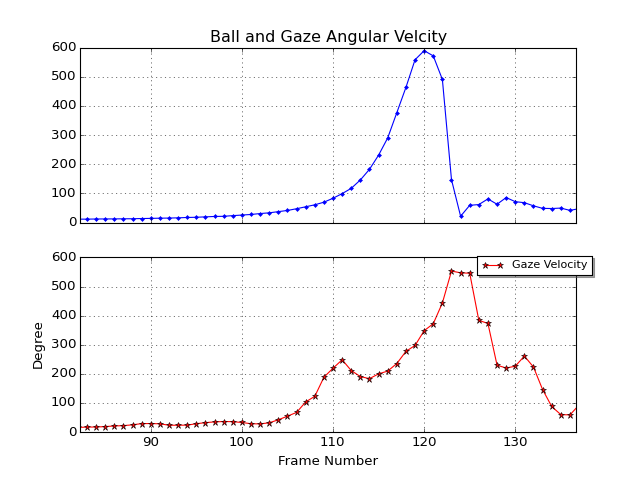

In [23]:
sessionDict['processed'] = processedDataFrame
trialNumber = 2
gbTrial = sessionDict['processed'].groupby(['trialNumber'])
gazeVelocity = gbTrial.get_group(trialNumber)['cycGazeVelocity_fr'].values
ballVelocity = gbTrial.get_group(trialNumber)['ballAngularVelocity_fr'].values
ballVelocity[-2] = ballVelocity[-1]

startFrame = 0
frameCount = len(gazeVelocity)

# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(range(frameCount), ballVelocity/1.8, label = 'Ball Velocity', c = 'b', marker = '.')
axarr[0].set_title('Ball and Gaze Angular Velcity')
axarr[0].grid(True)
axarr[1].plot(range(frameCount), gazeVelocity, label = 'Gaze Velocity', c = 'r', marker = '*')

#fig1 = plt.figure()
#plt.plot(range(frameCount), ballVelocity, label = 'Ball Velocity', c = 'b', marker = '.')
#plt.plot(range(frameCount), gazeVelocity, label = 'Gaze Velocity', c = 'r', marker = '*')

#plt.xlim(xmin, xmax)
#plt.ylim(ymin, ymax)
plt.xlabel('Frame Number')
plt.ylabel('Degree')
#plt.title('Ball and Gaze Angular Velcity')
plt.grid(True)
#plt.axis('equal')
legend = plt.legend(loc=[0.8,0.9], shadow=True, fontsize='small')# 'upper center'
plt.show()

In [ ]:
sessionDict['processed']['vizardDeltaT'].values